# LSTM Analysis 

Long Short-Term Memory (LSTM) networks, a special kind of Recurrent Neural Network (RNN), have emerged as a powerful tool for predicting time series data due to their ability to capture long-term dependencies and patterns. Unlike traditional neural networks, LSTMs can remember information over extended periods, making them particularly suitable for applications where historical context significantly influences future outcomes. This capability is especially valuable in financial markets, where past stock prices and trends can provide insightful cues for future movements.

In this analysis, we leverage the strengths of LSTM networks to predict the stock price of the Vanguard S&P 500 ETF ($VOO)



### 0. Importing Modules

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import seaborn as sns

import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

### 1. Data Preparation & Preprocessing



In [38]:
voo_data = pd.read_csv('../datasets/VOO_full.csv')
df = pd.read_csv('../datasets/VOO_full.csv')
display(voo_data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-01,354.549988,359.390015,354.500000,358.119995,340.781616,3721100
1,2021-03-02,358.380005,358.630005,355.160004,355.350006,338.145752,5462600
2,2021-03-03,354.700012,355.640015,350.559998,350.660004,333.682800,6317600
3,2021-03-04,350.489990,353.019989,341.920013,346.339996,329.571930,6604500
4,2021-03-05,349.769989,353.730011,342.589996,352.690002,335.614471,8721300
...,...,...,...,...,...,...,...
771,2024-03-22,479.869995,480.320007,478.820007,479.179993,479.179993,5876800
772,2024-03-25,477.730011,478.790009,477.549988,477.940002,477.940002,6081300
773,2024-03-26,479.059998,479.369995,476.429993,476.600006,476.600006,8073500
774,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400


In [39]:
# Convert the 'Date' column to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Now, focus on the 'Close' column
df_close = df[['Close']]
df_close

,Close
Date,
2021-03-01,358.119995
2021-03-02,355.350006
2021-03-03,350.660004
2021-03-04,346.339996
2021-03-05,352.690002
...,...
2024-03-22,479.179993
2024-03-25,477.940002
2024-03-26,476.600006


c:\Users\TAN UEI HORNG\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


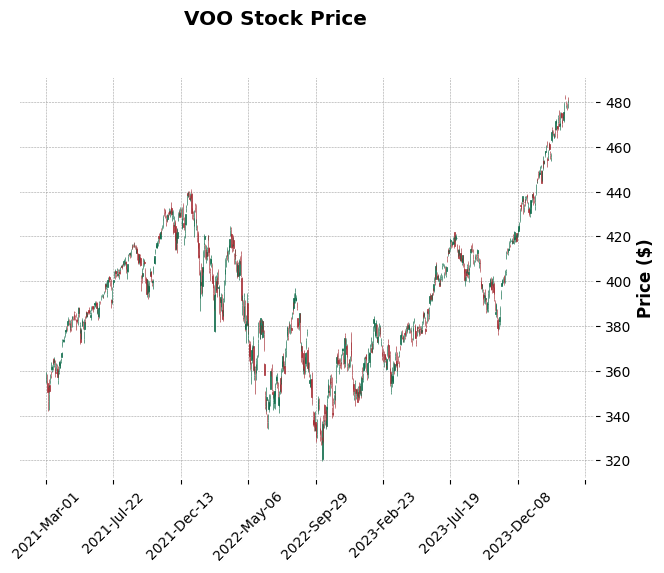

In [45]:
# Since mplfinance expects certain column names for the OHLC data, ensure your DataFrame columns are named appropriately
df = df[['Open', 'High', 'Low', 'Close']]

# Create the candlestick chart
mpf.plot(df, type='candle', style='charles', title='VOO Stock Price', ylabel='Price ($)')

### 2. Exploratory Data Analysis


In [46]:
#Summary Statistics
print(voo_data.describe())

             Open        High         Low       Close   Adj Close  \
count  776.000000  776.000000  776.000000  776.000000  776.000000   
mean   394.096753  396.413247  391.684588  394.226392  384.298414   
std     30.896275   30.462754   31.278122   30.913516   32.345366   
min    320.839996  330.579987  319.869995  327.640015  319.887482   
25%    370.890015  373.555001  367.797485  371.182503  360.895416   
50%    392.834992  394.875000  391.120011  393.509995  382.577424   
75%    413.307510  415.125008  411.475013  413.692504  402.873253   
max    482.619995  483.239990  481.209991  481.350006  480.760010   

             Volume  
count  7.760000e+02  
mean   4.837919e+06  
std    2.185098e+06  
min    1.351300e+06  
25%    3.417675e+06  
50%    4.278250e+06  
75%    5.576350e+06  
max    2.297070e+07  


In [47]:
# Check for Missing Values
print(voo_data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


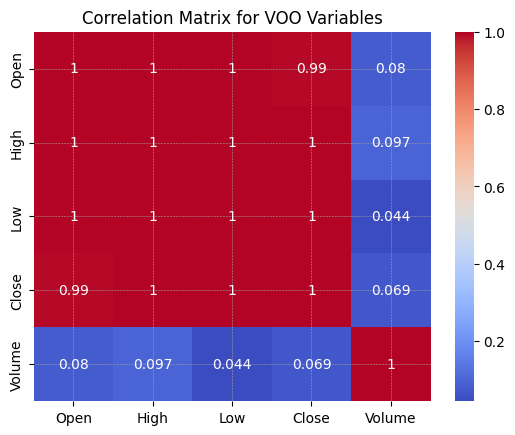

In [48]:
# Correlation Matrix
correlation_matrix = voo_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for VOO Variables')
plt.show()

From this heatmap, we can conclude that the Open, High, Low, and Close values are highly correlated with each other for VOO, meaning they tend to move together during the trading period. However, Volume does not strongly correlate with price movement, indicating that for VOO, volume changes are not necessarily associated with large changes in price. This can be useful information for trading strategies that might, for example, use volume as an indicator independent of price movements.

---

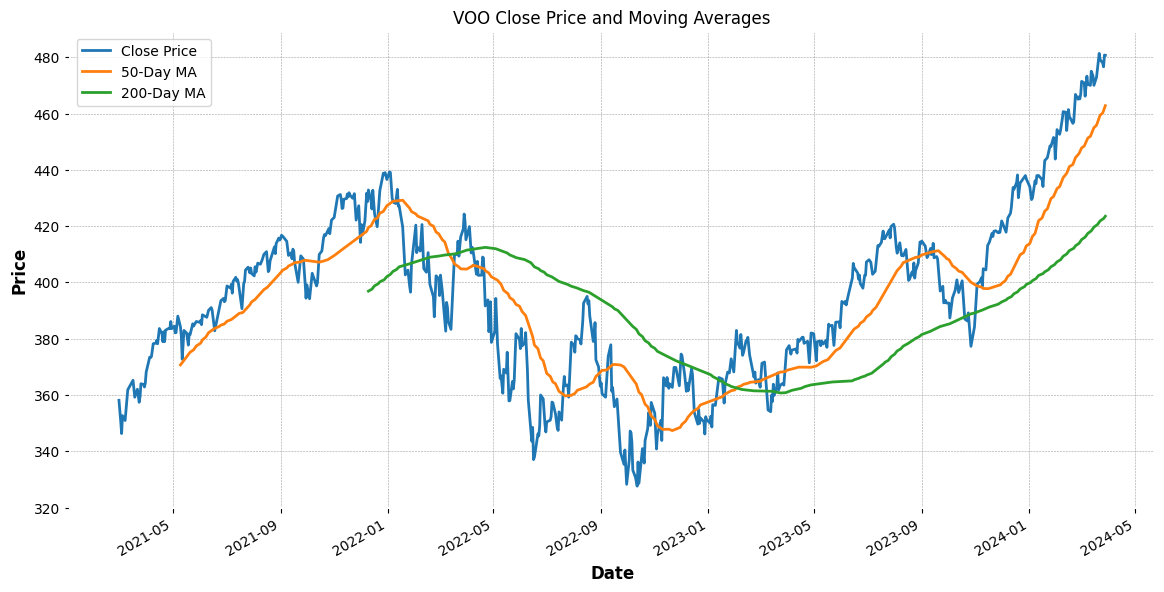

In [49]:
# Closing Price and Moving Averages on One Chart

plt.figure(figsize=(14, 7))

# Plotting the Closing Price
df['Close'].plot(label='Close Price')

# Short-term (50-day) and Long-term (200-day) Moving Averages
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()
df['MA50'].plot(label='50-Day MA')
df['MA200'].plot(label='200-Day MA')

plt.title('VOO Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In the chart, the MA200 starts later than the MA50 (50-day moving average) and the closing price line. This happens because a 200-day moving average requires 200 days of data before the first value can be calculated. Therefore, the MA200 line will begin to appear on the chart only after the first 200 days.

The 200-day moving average is used to determine the long-term market trend and smooth out price fluctuations. It's slower to respond to price changes than the 50-day moving average because it considers a larger set of data, which is why it appears smoother and starts later in the chart.

The overall chart shows the closing price of VOO, along with the short-term (MA50) and long-term (MA200) trends. The MA50 line reacts more quickly to recent price changes, while the MA200 provides a more gradual trend line that reflects longer-term price movements. When the closing price dips below these averages, it could be seen as a bearish signal, and when it's above, it could be bullish. The intersection points where the closing price or MA50 crosses the MA200 can be of particular interest to traders looking for trend reversals.

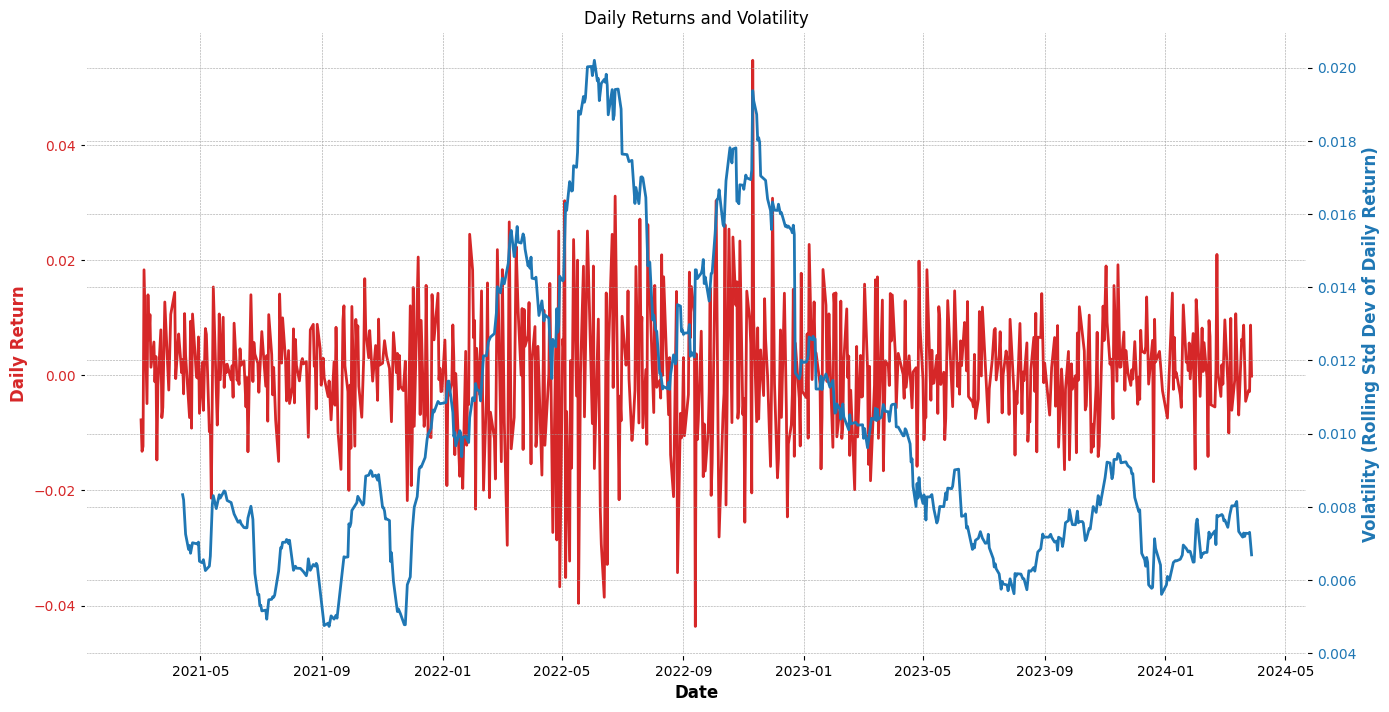

In [50]:
# Daily Returns and Volatility in a Single Chart
df['Daily Return'] = df['Close'].pct_change()

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return', color=color)
ax1.plot(df.index, df['Daily Return'], color=color, label='Daily Return')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Volatility (Rolling Std Dev of Daily Return)', color=color)  
ax2.plot(df.index, df['Daily Return'].rolling(window=30).std(), color=color, label='Rolling 30-Day Std Dev')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Daily Returns and Volatility')
plt.show()


When 

---


### 3. Training Set Preparation and Data Normalisation

In [77]:
start_date = '1/3/2021'
end_date = '28/3/2024'

df = df[start_date:end_date]

df

,Open,High,Low,Close,MA50,MA200,Daily Return,Change
Date,,,,,,,,
2021-03-01,354.549988,359.390015,354.500000,358.119995,NaN,NaN,NaN,3.570007
2021-03-02,358.380005,358.630005,355.160004,355.350006,NaN,NaN,-0.007735,-3.029999
2021-03-03,354.700012,355.640015,350.559998,350.660004,NaN,NaN,-0.013198,-4.040008
2021-03-04,350.489990,353.019989,341.920013,346.339996,NaN,NaN,-0.012320,-4.149994
2021-03-05,349.769989,353.730011,342.589996,352.690002,NaN,NaN,0.018335,2.920013
...,...,...,...,...,...,...,...,...
2024-02-22,463.220001,467.329987,462.320007,466.570007,443.480602,412.56825,0.021008,3.350006
2024-02-23,468.089996,468.869995,466.089996,466.779999,444.325002,413.00625,0.000450,-1.309997
2024-02-26,467.190002,467.589996,464.940002,465.070007,445.093002,413.44390,-0.003663,-2.119995


In [78]:
# Prepare training set
train_df = df_close['1/3/2021':'28/2/2024']

# Normalise data
scaler = MinMaxScaler(feature_range=(0,1))      
scaled_data = scaler.fit_transform(train_df['Close'].values.reshape(-1,1))

# Number of days to base prediction on:
N_PRED_DAYS = 50

x_train, y_train = [], []

for d in range(N_PRED_DAYS, len(scaled_data)):
    # Add previous days values to x_train
    x_train.append(scaled_data[d - N_PRED_DAYS: d, 0])
    # Add current day's value to y_train
    y_train.append(scaled_data[d, 0])

# Convert into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, y_train

(array([[[0.21905982],
         [0.19915189],
         [0.16544482],
         ...,
         [0.41425895],
         [0.43402322],
         [0.40671268]],
 
        [[0.19915189],
         [0.16544482],
         [0.13439689],
         ...,
         [0.43402322],
         [0.40671268],
         [0.38249228]],
 
        [[0.16544482],
         [0.13439689],
         [0.18003442],
         ...,
         [0.40671268],
         [0.38249228],
         [0.3240621 ]],
 
        ...,
 
        [[0.71172926],
         [0.75348576],
         [0.76261318],
         ...,
         [0.92949548],
         [0.99849079],
         [1.        ]],
 
        [[0.75348576],
         [0.76261318],
         [0.75786972],
         ...,
         [0.99849079],
         [1.        ],
         [0.98771028]],
 
        [[0.76261318],
         [0.75786972],
         [0.77547798],
         ...,
         [1.        ],
         [0.98771028],
         [0.993891  ]]]),
 array([0.38249228, 0.3240621 , 0.35590049, 0.39751332,

---

### 4. LSTM Model Building & Training

In [79]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

#### Training

In [80]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\TAN UEI HORNG\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
checkpointer = ModelCheckpoint(filepath='weights_best.weights.h5',  
                               verbose=2, 
                               save_best_only=True, 
                               save_weights_only=True,  
                               monitor='loss')

history = model.fit(x_train, 
                    y_train, 
                    epochs=35, 
                    batch_size=32,
                    callbacks=[checkpointer])


Epoch 1/35


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1159
Epoch 1: loss improved from inf to 0.05388, saving model to weights_best.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.1133
Epoch 2/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0152
Epoch 2: loss improved from 0.05388 to 0.01227, saving model to weights_best.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0151
Epoch 3/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0115
Epoch 3: loss improved from 0.01227 to 0.01167, saving model to weights_best.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0115
Epoch 4/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0106
Epoch 4: loss improved from 0.01167 to 0.00996, saving model to weights_best.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0106
Epoch 5/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0093
Epoch 5: loss improved from 0.00996 to 0.00825, saving model to weights_best.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━

---

### 5. Predictions and Visualization

In [90]:
# Prepare test dataset 
test_df = df_close['1/3/2023':'28/3/2024']
actual_prices = test_df['Close'].values
display(test_df)

model_inputs = df_close[len(train_df) - N_PRED_DAYS:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)




,Close
Date,
2023-01-03,349.989990
2023-01-04,352.510010
2023-01-05,348.660004
2023-01-06,356.589996
2023-01-09,356.329987
...,...
2024-03-22,479.179993
2024-03-25,477.940002
2024-03-26,476.600006


In [84]:
x_test = []

for d in range(N_PRED_DAYS, len(model_inputs)):
    x_test.append(model_inputs[d - N_PRED_DAYS: d, 0])

# Convert to numpy array and reshape to 3D array with appropriate dimensions for LSTM model
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict the prices 
predicted_prices = model.predict(x_test)
# Perform an inverse transform to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


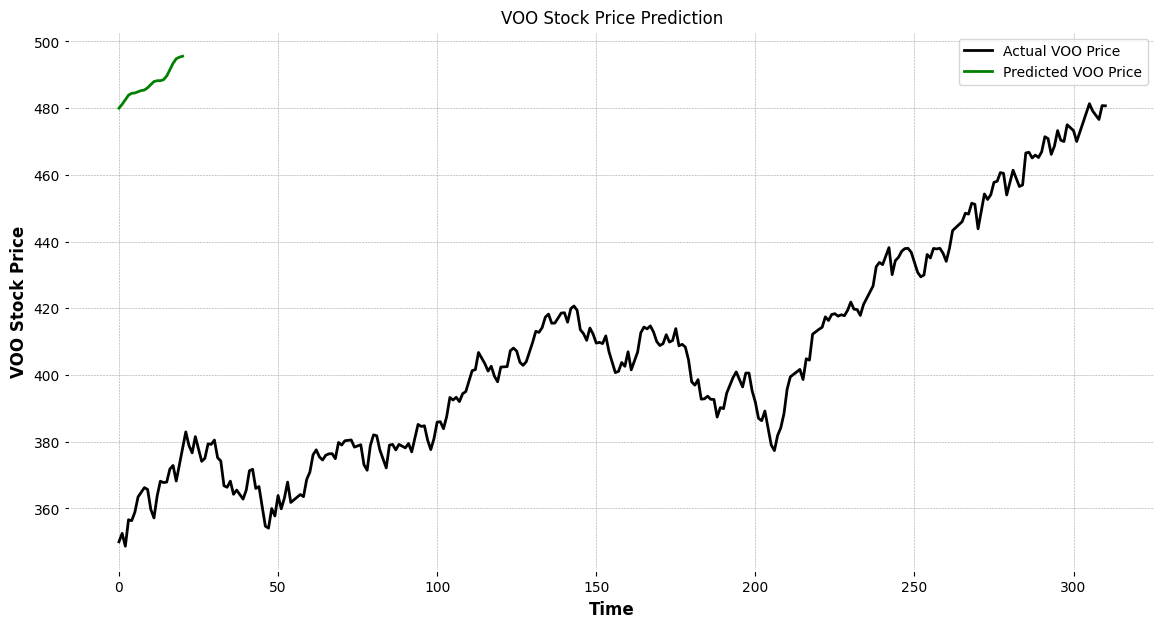

In [107]:
# Plotting the actual vs. predicted prices
plt.figure(figsize=(14,7))
plt.plot(actual_prices, color='black', label='Actual VOO Price')
plt.plot(predicted_prices, color='green', label='Predicted VOO Price')
plt.title('VOO Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VOO Stock Price')
plt.legend()
plt.show()



ValueError: x and y must have same first dimension, but have shapes (311,) and (21,)

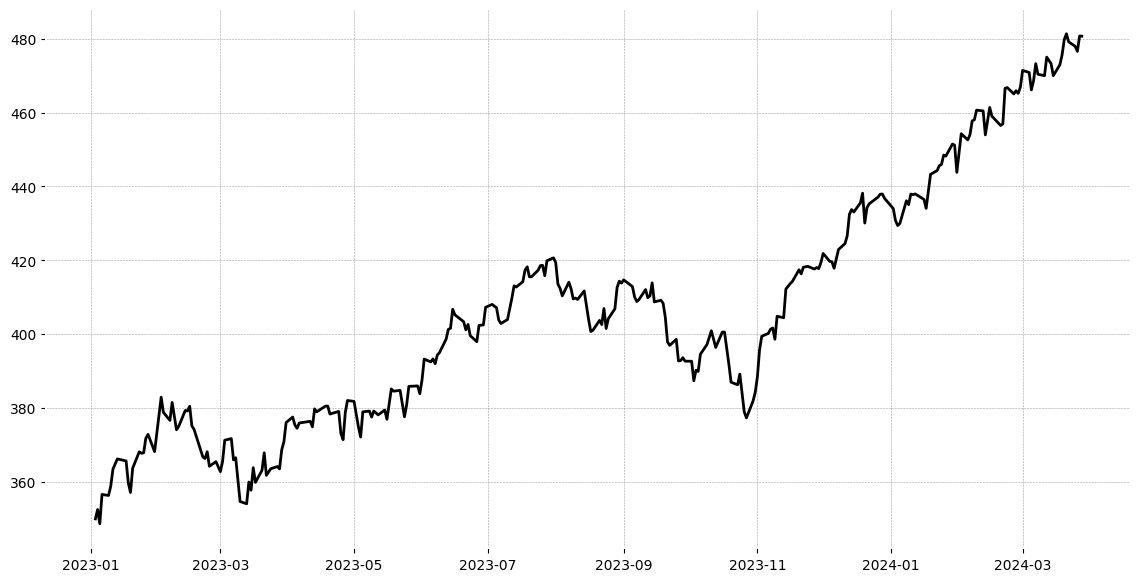

In [108]:
# Assuming 'dates' is a list or array of datetime objects corresponding to the actual prices
plt.figure(figsize=(14,7))
dates = test_df.index
plt.plot(dates, actual_prices, color='black', label='Actual VOO Price')
plt.plot(dates, predicted_prices, color='green', label='Predicted VOO Price')
plt.title('VOO Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('VOO Stock Price')
plt.legend()
plt.show()

### 6. Evaluation & Observation

---